**A Week After the Election - Looking at the week before and the week after the election through factors**

I always find it interesting, and sometimes useful to compare the performance of global factors (e.g. large cap vs small cap, value vs growth, etc.) before and after a material event takes place to try and gain insight into where the money is flowing. For the purposes of this analysis, we are going to look at the week before the election, the week after, and the week before/after combined. I have compiled a list of over 80 ETFs that I think cover every possible way one could slice and dice the markets (for both fixed income and equities). More on that below. Skim through the code until you see charts if you just want to cut to the chase..

data sources: tiingo for security price data

In [152]:
etf_factors = pd.read_csv('etf_types.csv')

Here I am reading in a CSV file I created to make my analysis of factors easier. A small output of what that spreadsheet looks like is below. I assembled over 80 ETFs that should cover most of the ways you can group equity and fixed income securities. For equity securities I have it broken down by industry, sector, global style (growth vs. value), style box (large value and growth, mid value and growth, etc.), qualitative (buybacks, IPOs, etc.), and style (momentum vs growth). For fixed income I have it broken down by duration, gov agencies, credit, and international credit. It is probably a bit overkill, but with the amount of ETFs and ways you can break apart and combine the markets these days, why not?

As of the start of this week, I have been reading about the "work-from-home" trade unwinding as news about a possible vaccine is back in the press. Luckily, a new ETF came out back in June that tracks a basket of securities that benefit from remote work becoming a bigger part of people's lives, so I have included the WFH ETF in our analysis to see if the trade is really unwinding.

In [153]:
etf_factors.head()

,ticker,asset_class,type,factor
0,IWF,equity,style,growth
1,MTUM,equity,style,momentum
2,IJR,equity,style,small_cap
3,IWD,equity,style,value
4,USMV,equity,style,low_volatility


Now I am going to extract the column that contains the tickers so I can go and grab all of the historical adjusted close prices, and ultimately calculate the returns for each for the week before, after and before/after combined with respect to the election date.

In [154]:
tickers = etf_factors['ticker'].to_list()

Below I am grabbing the adjusted close prices for each ticker by looping through the list above and storing the prices into a dataframe that we can use for our analysis later. I am discarding any of the ETFs that do not have price histories within the last 5 days, because that most likely means they no longer exist.

In [155]:
adjusted_close = pd.DataFrame(columns=tickers)
null_tickers = []

for ticker in tickers:
  try:
    data_panel = web.DataReader([ticker], "tiingo").loc[ticker]['adjClose'].to_frame()
    data_panel.columns = [ticker]
    data_panel.index = pd.to_datetime(data_panel.index)
    if data_panel.index.max().tz_localize(None) < datetime.today() - relativedelta(days=5):
        print("{} most recent date is {}".format(ticker, str(data_panel.index.max())))
    else:
        adjusted_close[ticker] = data_panel[ticker]
  except:
    null_tickers.append(ticker)
    print("{} not found".format(ticker))

In [156]:
adjusted_close.index = adjusted_close.index.tz_localize(None)

The data ultimately looks like this:

In [157]:
adjusted_close.head()

,IWF,MTUM,IJR,IWD,USMV,VYM,RSP,IPO,CSD,PSP,...,XME,XOP,OIH,VNQ,KRE,XRT,SMH,IGV,PHO,SPY
date,,,,,,,,,,,,,,,,,,,,,
2015-11-13,92.486382,66.595300,51.670787,86.637630,36.797070,56.480442,69.833722,20.427287,36.750210,7.788251,...,14.584420,136.681076,536.001690,62.034474,39.078013,39.314857,48.921852,100.122519,21.324911,183.486465
2015-11-16,93.700955,67.457618,52.247439,87.988721,37.337938,57.349503,70.922301,20.549929,37.011711,7.926806,...,14.757827,142.275118,550.163607,62.748633,39.515287,39.917988,49.553581,100.994327,21.520105,186.276720
2015-11-17,93.738616,67.729436,52.117228,87.767955,37.292866,57.187619,70.766790,20.505778,36.936996,7.853882,...,14.274113,139.552684,540.124779,62.748633,39.649146,39.769525,50.055249,101.553934,21.178516,186.140831
2015-11-18,95.395707,68.891596,52.889197,89.004247,37.725561,57.903316,71.891960,20.760874,37.502025,7.934098,...,14.803460,142.386998,557.692728,63.300483,40.220279,40.465445,50.315373,102.466977,21.568903,189.094153
2015-11-19,95.348630,68.469904,52.749684,88.924771,37.734575,58.031120,71.818778,20.751063,37.525373,7.934098,...,14.757827,138.694931,544.427134,63.495254,40.059559,40.159240,50.705558,103.654915,21.461547,188.931086


Now that we have the adjusted closes for each ticker lined up. I am going to read in another file that contains the start and end date for each of the intervals we want to examine as mentioned earlier.

In [158]:
date_windows = pd.read_csv('date_windows.csv')

That data looks like this:

In [159]:
date_windows

,start,end,name
0,10/27/2020,11/3/2020,week_before_election
1,11/4/2020,11/10/2020,week_after_election
2,10/27/2020,11/10/2020,week_before_after_election


In [160]:
date_windows['start'] = pd.to_datetime(date_windows['start'])
date_windows['end'] = pd.to_datetime(date_windows['end'])

Now that we have the two raw datasets we needed to begin calculating the returns needed to finish our analysis and begin examining, I am going to create an empty dataframe with the tickers as the index (the first column), and the three time periods as the columns so we can fill it in below with the calculated returns.

In [161]:
returns = pd.DataFrame(index=tickers, columns=date_windows['name'].to_list())

Now I am going to loop through each ticker, then through each of the 3 date intervals, and calculate the returns for each and then store it back into the empty dataframe created in the step above.

In [162]:
for ticker in tickers:
    for i, r in date_windows.iterrows():
        returns.loc[ticker, r['name']] = (adjusted_close[ticker].loc[str(r['end'])] - adjusted_close[ticker].loc[str(r['start'])])/adjusted_close[ticker].loc[str(r['start'])]

A sample of what that looks like when it is all said and done can be seen below:

In [163]:
returns.head()

,week_before_election,week_after_election,week_before_after_election
IWF,-0.0257959,-0.00857564,0.00808393
MTUM,-0.0206123,-0.0235752,-0.000743394
IJR,0.0172716,0.0965582,0.104844
IWD,0.0153382,0.0701016,0.0862459
USMV,0.000157257,0.0357698,0.0473345


In [164]:
etf_factors = etf_factors.set_index('ticker')

Okay - now one final step and then we can begin with the actual analysis! To make it easier to know which segment of the market each ticker is going to represent, I am going to recombine the returns we calculated above with the original etf table we read in at the beginning of the notebook. This will add a few columns to allow us to filter, slice and dice the data into different groups for comparison purposes.

In [165]:
full_dataframe = pd.merge(etf_factors, returns, left_index=True, right_index=True)

In [166]:
full_dataframe = full_dataframe.set_index('factor')

And we are good to go. You can see what the final dataset looks like below:

In [167]:
full_dataframe.head()

,asset_class,type,week_before_election,week_after_election,week_before_after_election
factor,,,,,
growth,equity,style,-0.0257959,-0.00857564,0.00808393
momentum,equity,style,-0.0206123,-0.0235752,-0.000743394
small_cap,equity,style,0.0172716,0.0965582,0.104844
value,equity,style,0.0153382,0.0701016,0.0862459
low_volatility,equity,style,0.000157257,0.0357698,0.0473345


My preference is to start out as high level as possible and work our way down until we are more granular. To do that, we will first split the return data into two sets, one for equities and one for fixed income. Once we do that, we will chart each by time period to make it easier to see.

In [168]:
fixed_income = full_dataframe[full_dataframe['asset_class'] == 'fixed_income']
equity = full_dataframe[full_dataframe['asset_class'] == 'equity']

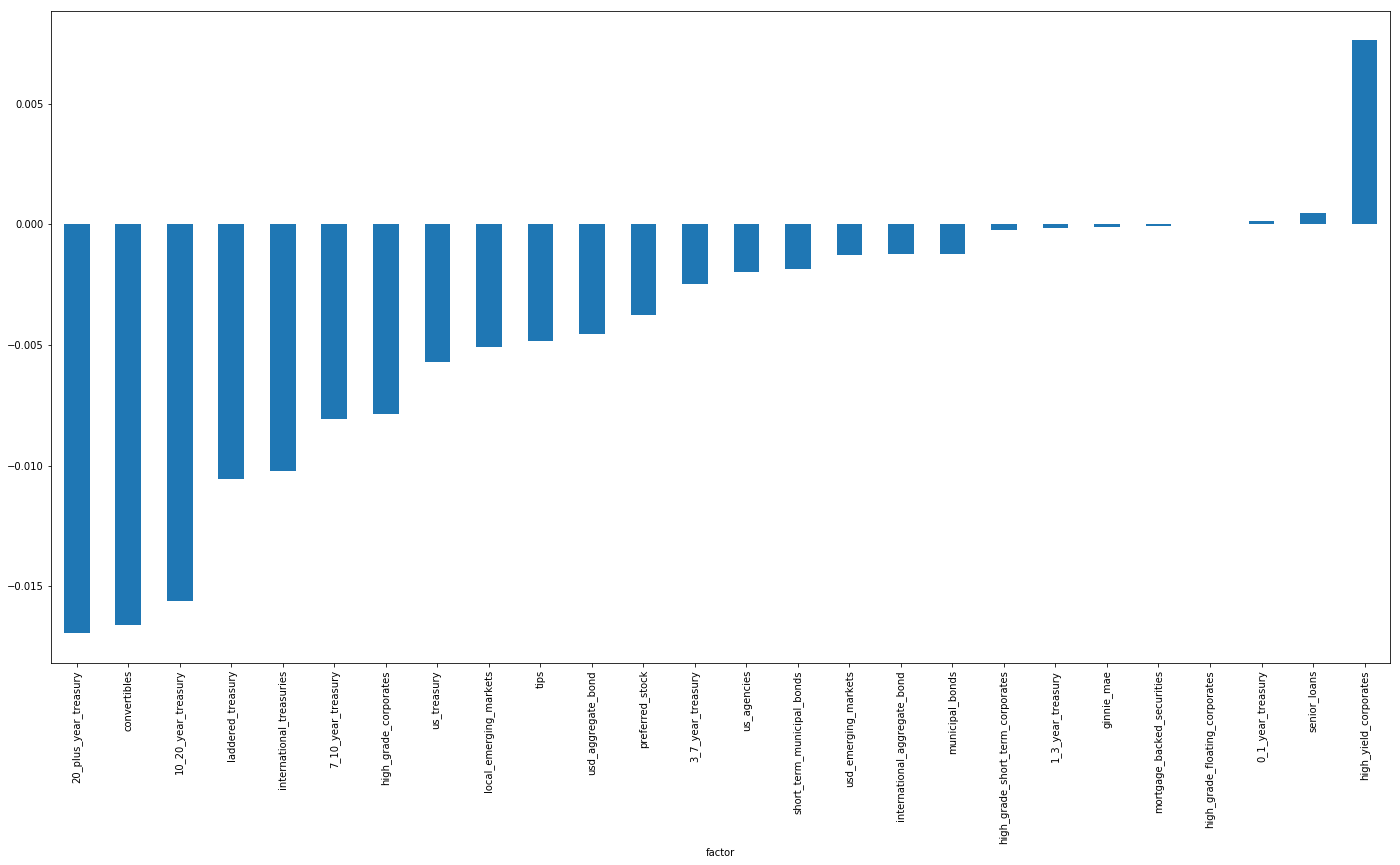

In [169]:
fixed_income['week_before_election'].sort_values().plot(kind='bar', figsize=(24, 12))

The week before the election, only 3 were positive and only 2 of those were meaningful. Senior loans and high yield corporates, which are risk-on fixed income asset classes. A tough week for fixed income in general, but still the worst asset class (20+ year treasuries) was down just over 1.5% so nothing to panic about, but still pretty underwhelming.

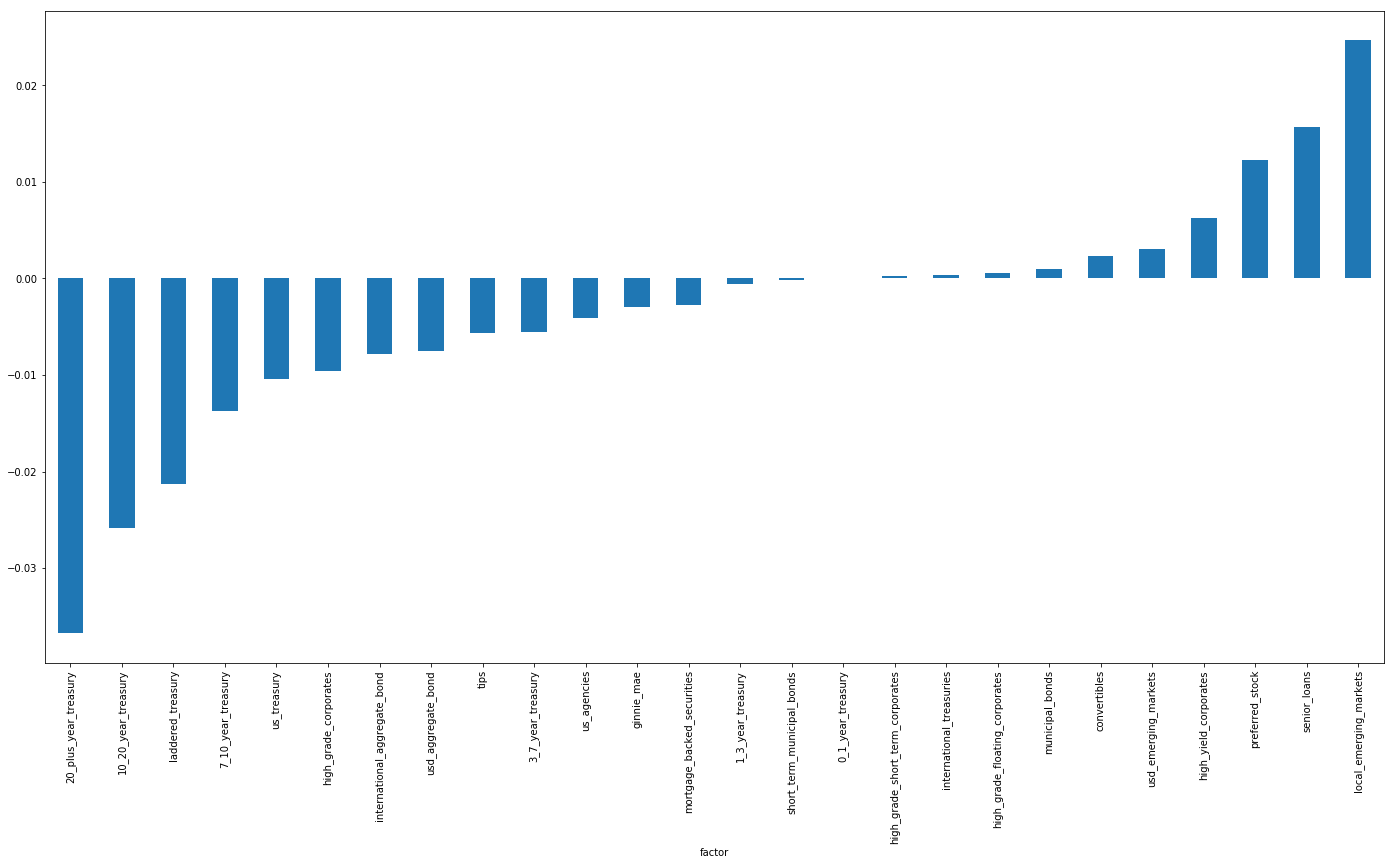

In [170]:
fixed_income['week_after_election'].sort_values().plot(kind='bar', figsize=(24, 12))

This one is a bit more interesting. This time, the top 5 positive performers were Local Emerging Market Bonds, Senior Loans, Preferred Stock, High Yield Corporates, and US Dollar Emerging Market Bonds. These are all risk-on asset classes in fixed income world. All of the negative performers are assets classes that are very sensitive to yield curve changes. We will look at the yield curve later in the analysis, but judging by the returns and the order of magnitude, it would appear as though the entire yield curve jumped upwards (rates went up across the board). I am cheating a bit here, but still interesting. The longest duration treasuries went down the most, which is not surprising because they are most sensitive to changes in the yield curve (in the US at least).

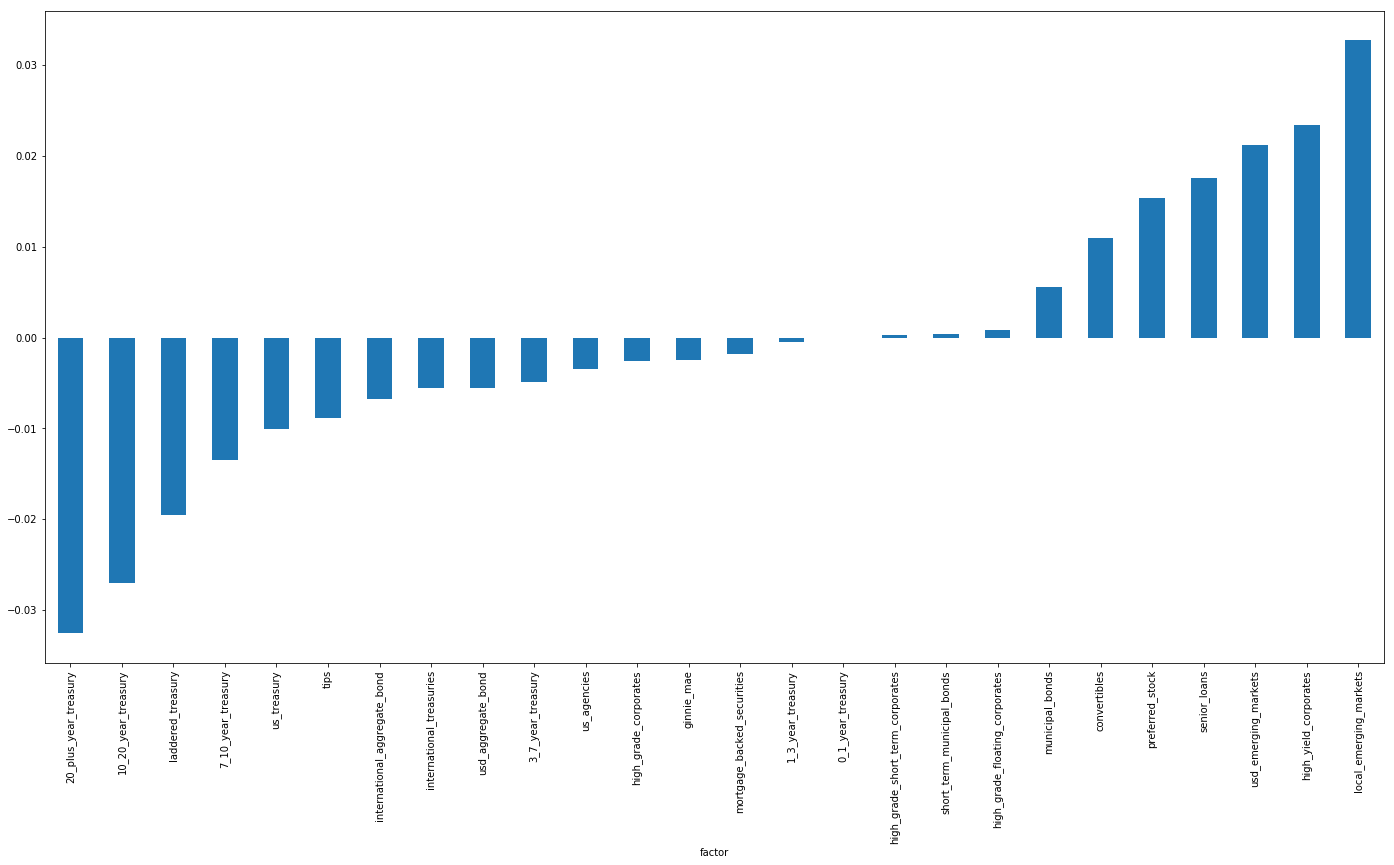

In [171]:
fixed_income['week_before_after_election'].sort_values().plot(kind='bar', figsize=(24, 12))

Not much insight gained from combining the two other than the picture looks almost identical to the week after the election. This means that the returns leading up to the election were relatively meaningless, and the real moves came after the election which is the returns from the week after look identical when combined with the week prior.

Now lets look at equities. It should be a little bit more interesting.

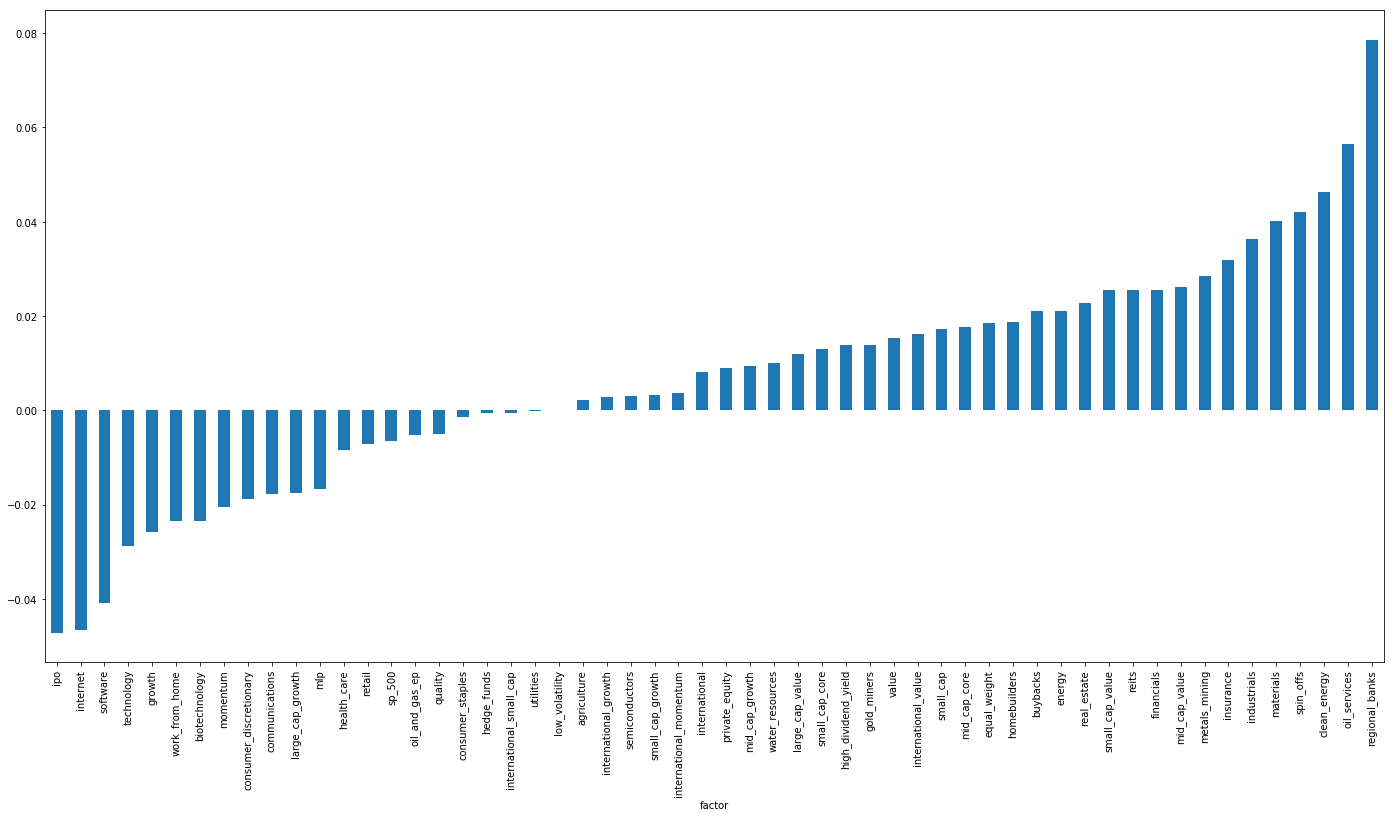

In [172]:
equity['week_before_election'].sort_values().plot(kind='bar', figsize=(24, 12))

The week leading up to the election looks much different than it did for fixed income. The worst performers were the darlings of 2020 so far. IPO, Internet, Software, Tech and Growth have been the place to be as an investor recently and it looks like that may have started to reverse course a bit leading up to the election. The three top performers were regional banks, oil services, and clean energy which Regional Banks were head and shoulders above the rest. Not sure what to make of this yet, but the week leading up to the election so far looks like the market had already started to shift towards what ultimately played out after the election. We will dig in more below. 

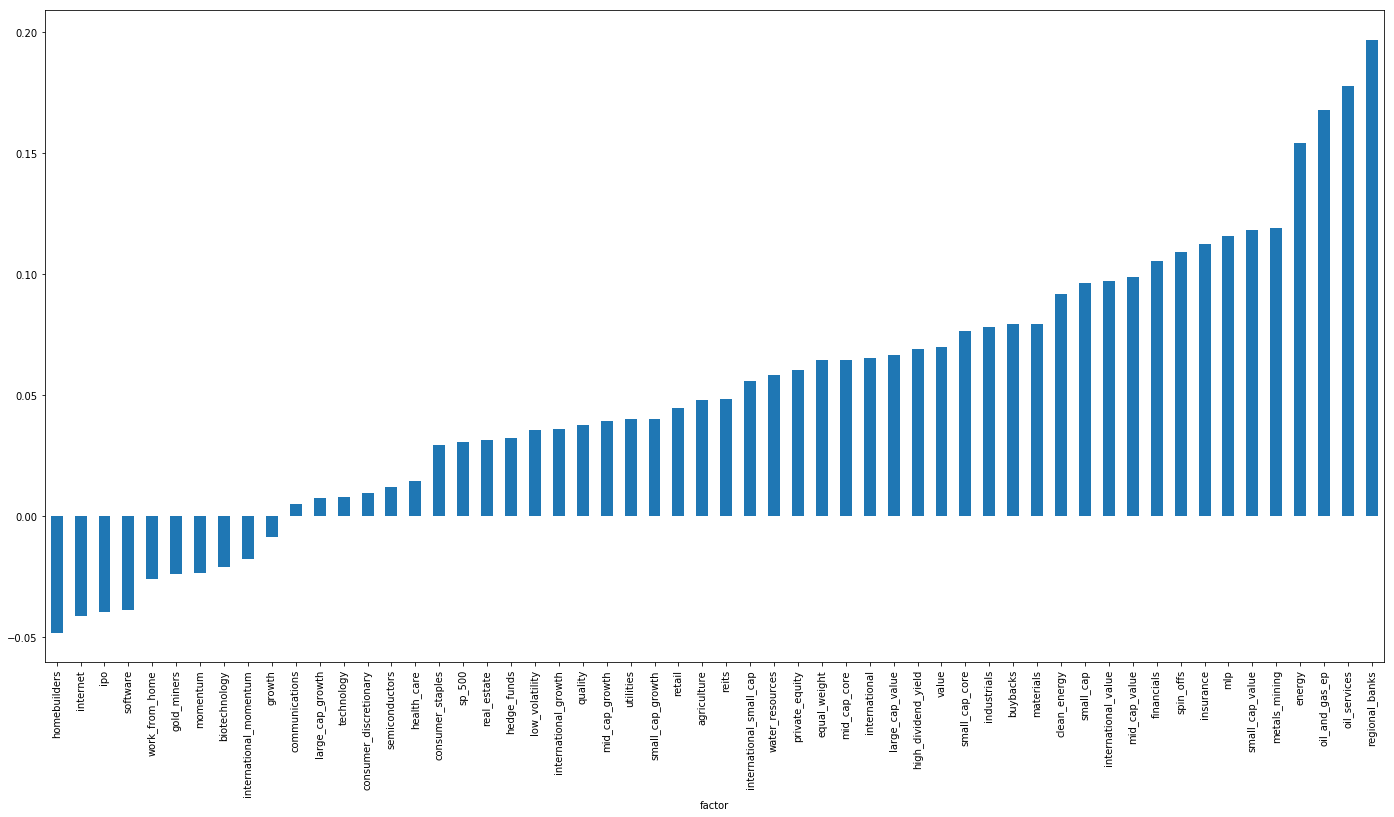

In [173]:
equity['week_after_election'].sort_values().plot(kind='bar', figsize=(24, 12))

The results for the week after the election are similar to what happened the week prior, but homebuilders sunk to the bottom of the pile. They were in the top 20 performance wise the week before so this one is a bit puzzling. The rest of the performance was largely a continuation of the trends from the week before the election. Most of the negative performance does look like a possible unwinding of the work-from-home trade. The top holding in the IPO ETF is actually Zoom, so IPO has been behaving much like a work-from-home trade, and the work-from-home ETF is not far behind in negative performance. For both Fixed Income and Equity, the market appears to have done a pretty good job getting the trades right before the election started and once more certainty (via the election) was delivered, it was just a higher conviction movement in the same trades (excluding homebuilders of course). Most of what the pundits and news outlets are saying is that homebuilders were also a big pandemic play (not necessarily work-from-home but correlated with the pandemic). Interest rates also went up quite a bit after the election as we saw in the fixed income charts previously, which could have been what propelled them to the bottom of the pack the week after the election.

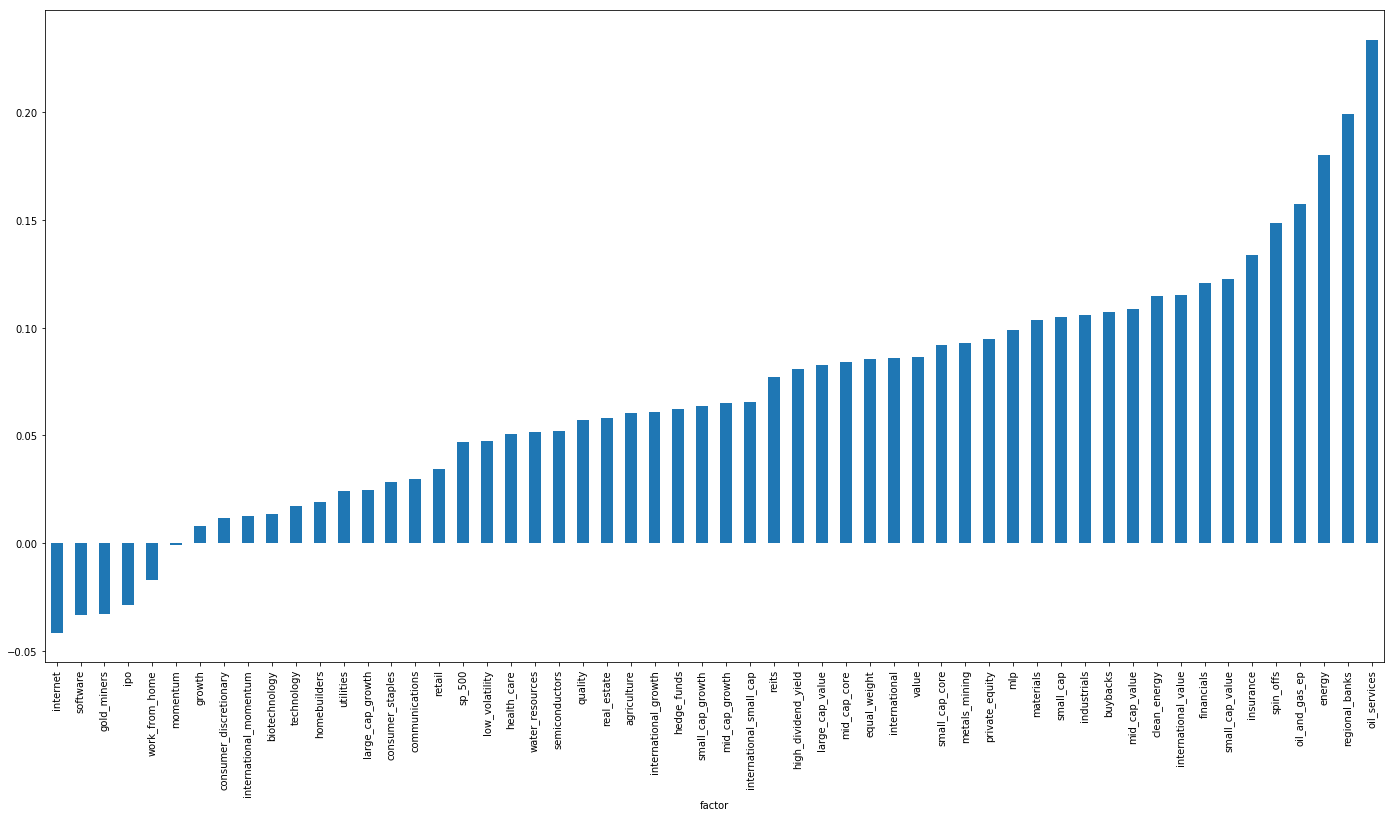

In [174]:
equity['week_before_after_election'].sort_values().plot(kind='bar', figsize=(24, 12))

Again, like we saw in fixed income, the performance over both weeks looks very similar to the week after the election since the performance numbers were much larger as a whole. Not much else to see here. 

Before we take a look at the yield curve, I think it would be helpful to look at the same 3 time periods, but lets get a little more granular. I am going to run them all at once, but this analysis will be grouped by "type" from the spreadsheet I showed earlier.

In [175]:
full_dataframe = full_dataframe[full_dataframe['type'] != 'broad_market']

In [176]:
all_types = list(set(full_dataframe['type'].to_list()))
all_periods = date_windows['name'].to_list()

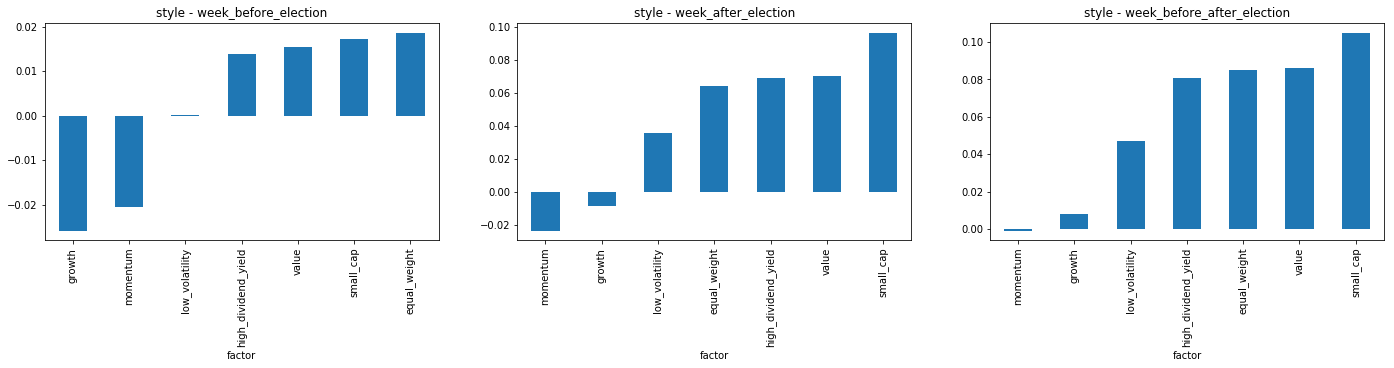

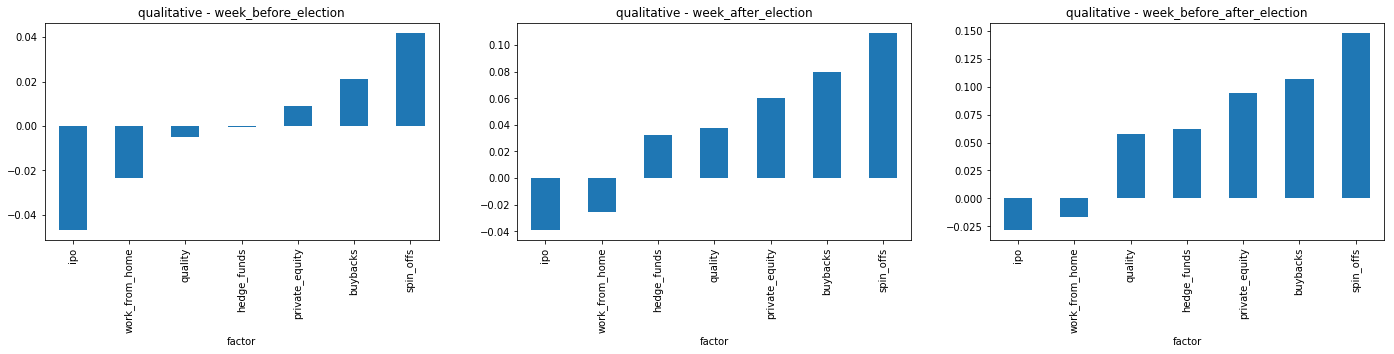

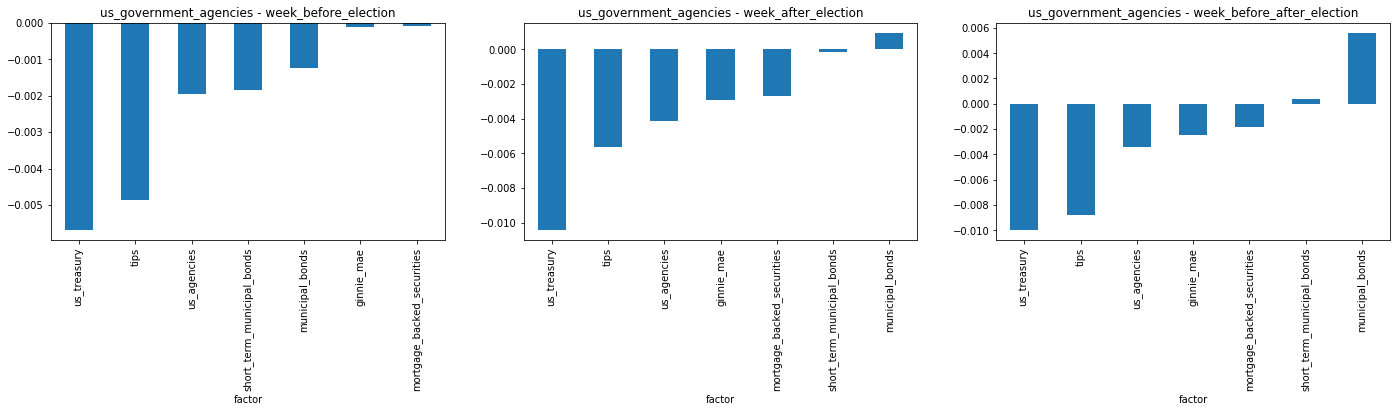

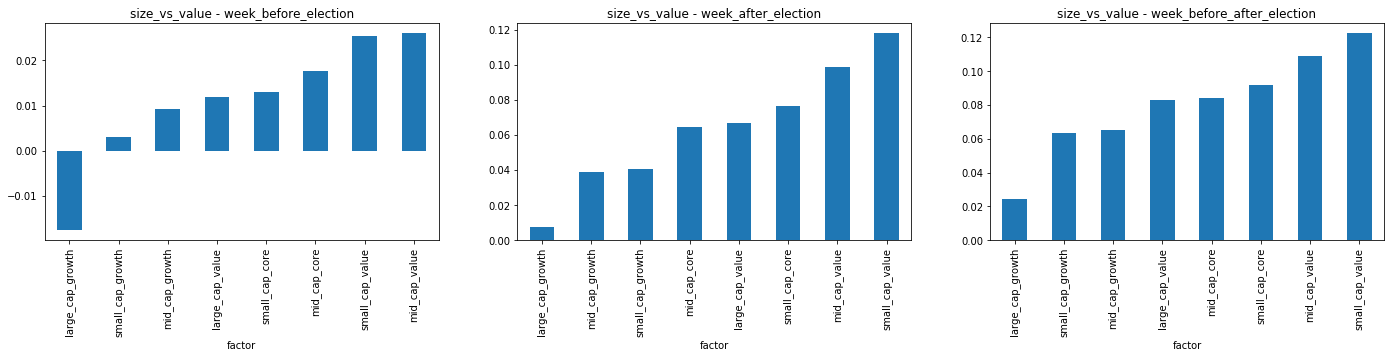

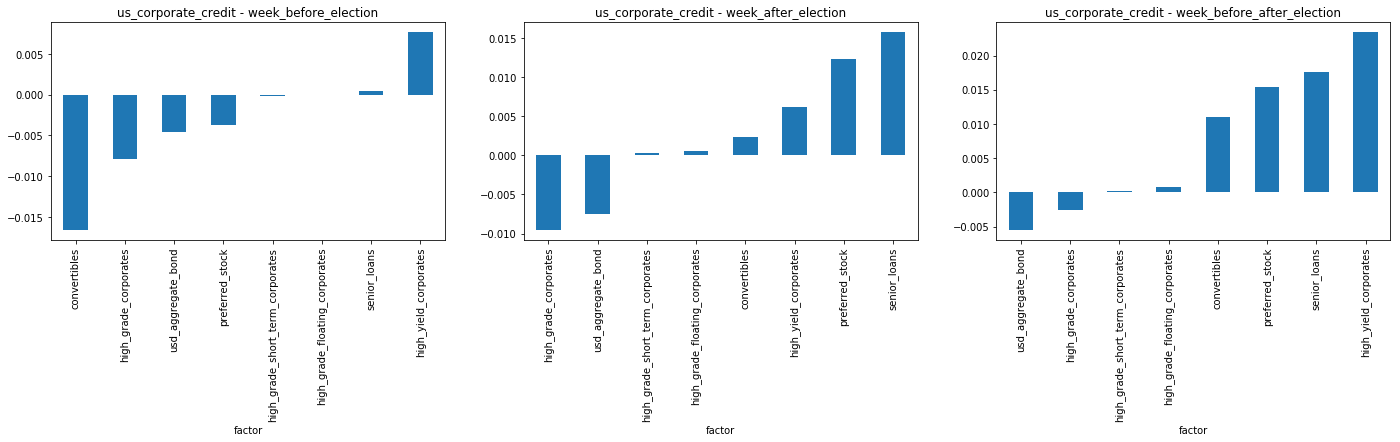

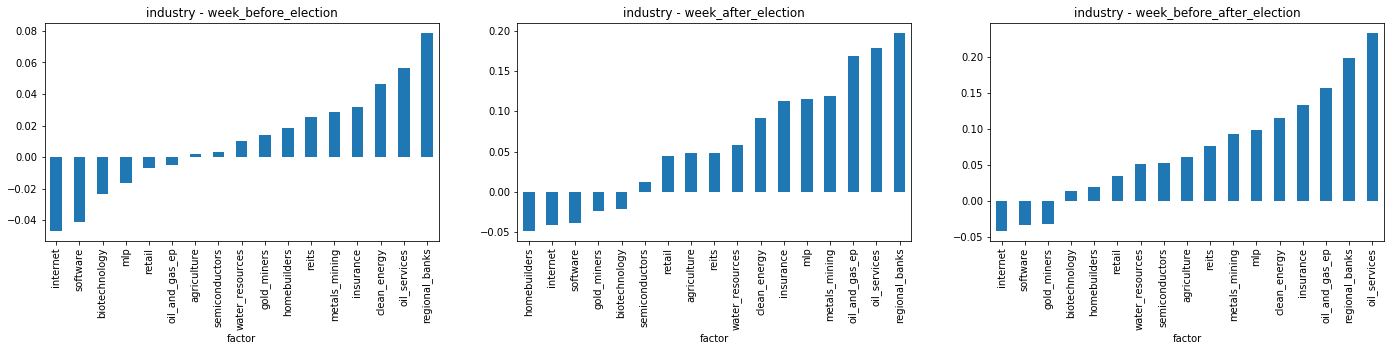

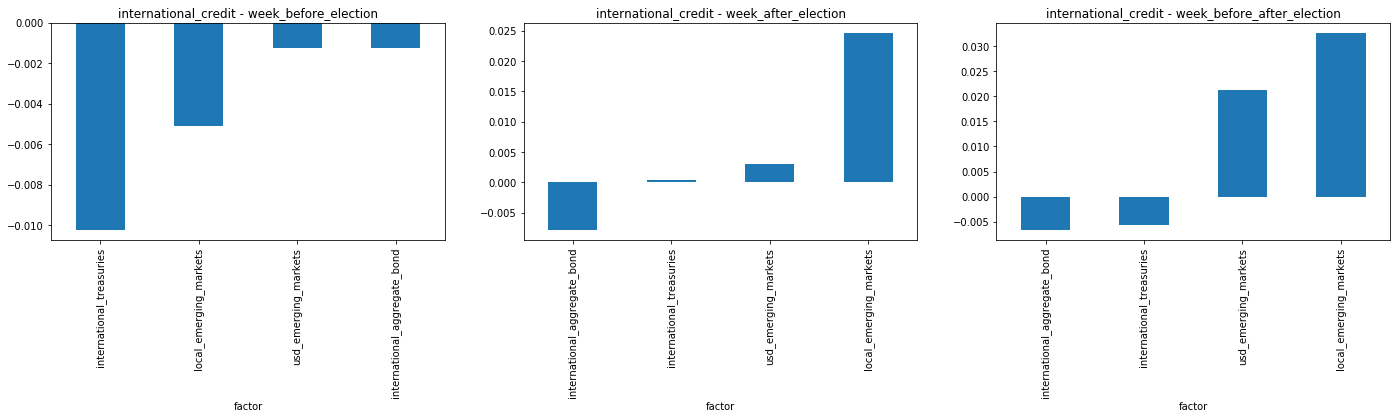

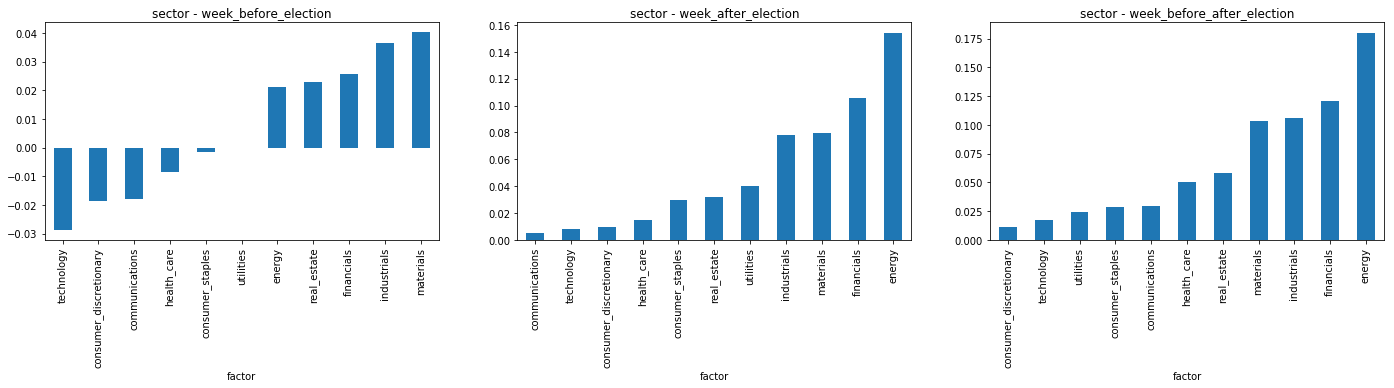

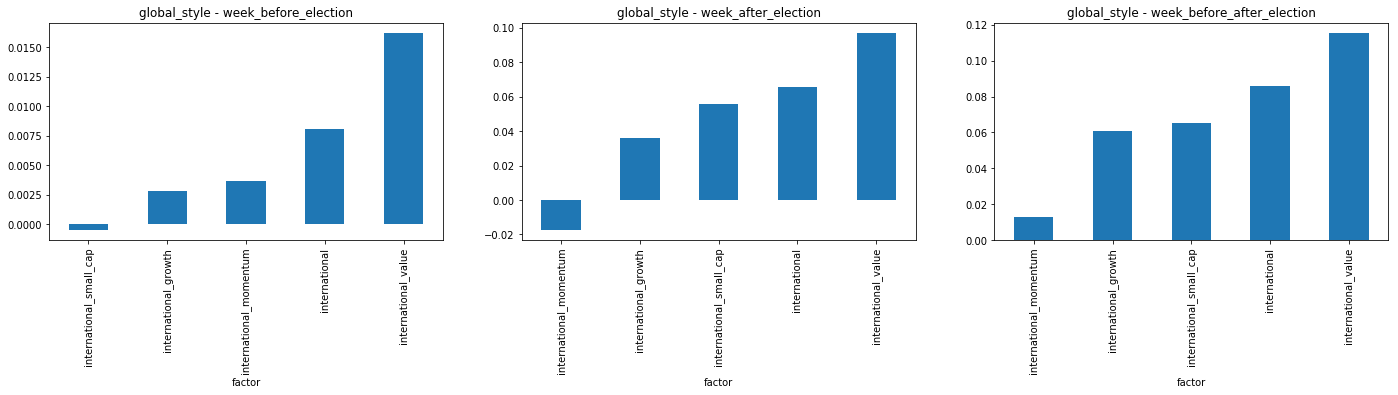

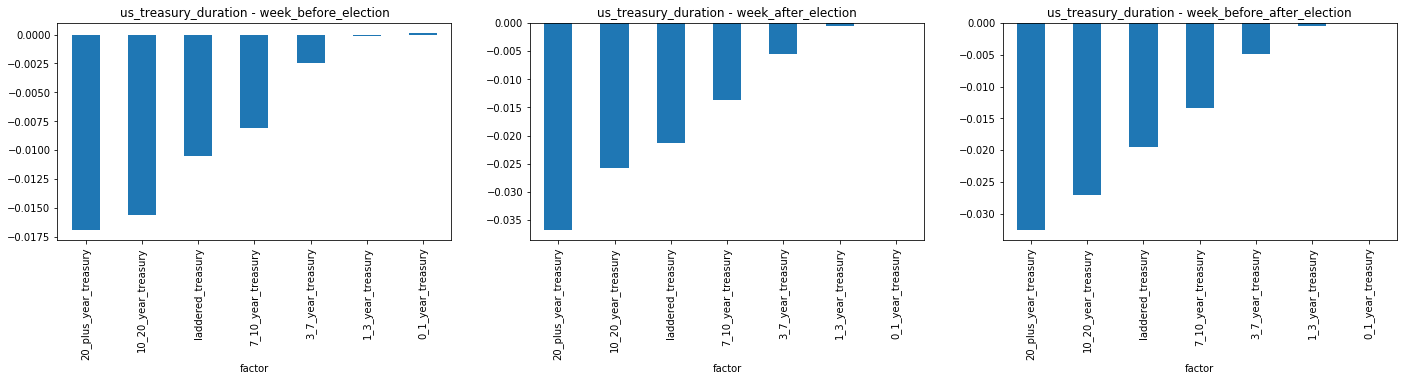

In [179]:
for types in all_types:
    df_list = []
    df = full_dataframe[full_dataframe['type'] == types]
    for period in all_periods:
        df_list.append(df[period].sort_values())
    

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 4))
   
    # plot counter
    count=0
    for c in range(len(all_periods)):
        df_list[count].plot(kind='bar', ax=axes[c], title="{} - {}".format(types, all_periods[c]))
        count+=1

        

Lot's of graphs - so lets start from the top with style. I will layout each category with what I think the market is telling us about the new administration:

1. Style - the market is telling us that small caps and value are back in vogue, and that momentum and growth will not.
2. Qualitative - looks largely like a reversal of the work-from-home trade. The private equity ETF correlates more to microcap equities, so the performance probably has more to do with favoring small caps than it does about private equity.
3. Government Agencies - this group is telling us that interest rates may be going up a lot sooner than what would happen under the Trump administration (possibly), and municipal bonds are the only positive performer post election. That may be a result of anticipated relief and funding for struggling municipalities under Biden's control.
4. Size vs Value - the market looks like it is going all in on small cap and value. Last month when I reviewed the same set of investments, I mentioned that companies in the small cap AND value camp look like a good place to start putting some cash to work. We will see if this continues to hold up down the road but very strong trend so far.
5. Corporate Credit - the junkier the better here - market appears to have started to reign in default estimates as a result of a potential vaccine. This looks like a good trend so far.
6. Industry - metals and mining, oil and gas, and regional banks appear to be the industry picks so far after the election.
7. International Credit - here it looks like the market has started to price in some potential improvements in Emerging Markets as a result of the election outcome. Possibly from lower probability of tariffs and protectionism from Biden and better relations with China.
8. Sectors - Energy, financials, materials and industrials look like the favorites. Energy is probably more of a result of the vaccine news and the economy reopening than the election. All sectors were actually positive the week after the election which is interesting.
9. Global Style - This looks somewhat similar to what is happening in the US. Money starting to shift towards value and smaller cap companies. This one is worth keeping an eye on as most US investors are heavily concentrated in US Megacaps right now, so may have room to run in developed markets outside of the US.
10. US Treasury Duration - all negative performance after the election. We will look at the yield curve shift below, but I have a feeling we will see the entire yield curve moving upwards after the election.

Normally I would download this data via API but I am rather exhausted after looking at all of this data. Using my Quandl.com subscription I went and downloaded all of the yield curve data (you can get it here if you sign up for a free account https://www.quandl.com/data/USTREASURY/YIELD-Treasury-Yield-Curve-Rates)

In [180]:
yield_curve = pd.read_csv('USTREASURY-YIELD.csv', index_col=0)

In [181]:
yield_curve

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2020-11-10,0.09,0.09,0.10,0.11,0.12,0.19,0.26,0.46,0.72,0.98,1.53,1.75
2020-11-09,0.10,0.10,0.11,0.11,0.12,0.17,0.25,0.44,0.70,0.96,1.51,1.73
2020-11-06,0.10,0.10,0.10,0.11,0.12,0.16,0.21,0.36,0.59,0.83,1.37,1.60
2020-11-05,0.09,0.10,0.10,0.10,0.12,0.14,0.18,0.33,0.56,0.79,1.32,1.54
2020-11-04,0.08,0.09,0.10,0.10,0.12,0.14,0.18,0.33,0.55,0.78,1.33,1.55
2020-11-03,0.09,0.10,0.10,0.12,0.14,0.17,0.21,0.39,0.65,0.90,1.44,1.66
2020-11-02,0.09,0.09,0.09,0.11,0.13,0.16,0.20,0.38,0.63,0.87,1.41,1.63
2020-10-30,0.08,0.09,0.09,0.11,0.13,0.14,0.19,0.38,0.64,0.88,1.43,1.65
2020-10-29,0.08,0.10,0.09,0.10,0.12,0.16,0.20,0.38,0.61,0.85,1.39,1.62


I am going to pick 3 dates to plot on a line chart so it is less busy. 1 week before the election, the day of the election, and yesterday.

In [183]:
yield_curve = yield_curve.loc[['2020-11-10', '2020-11-03', '2020-10-27']]

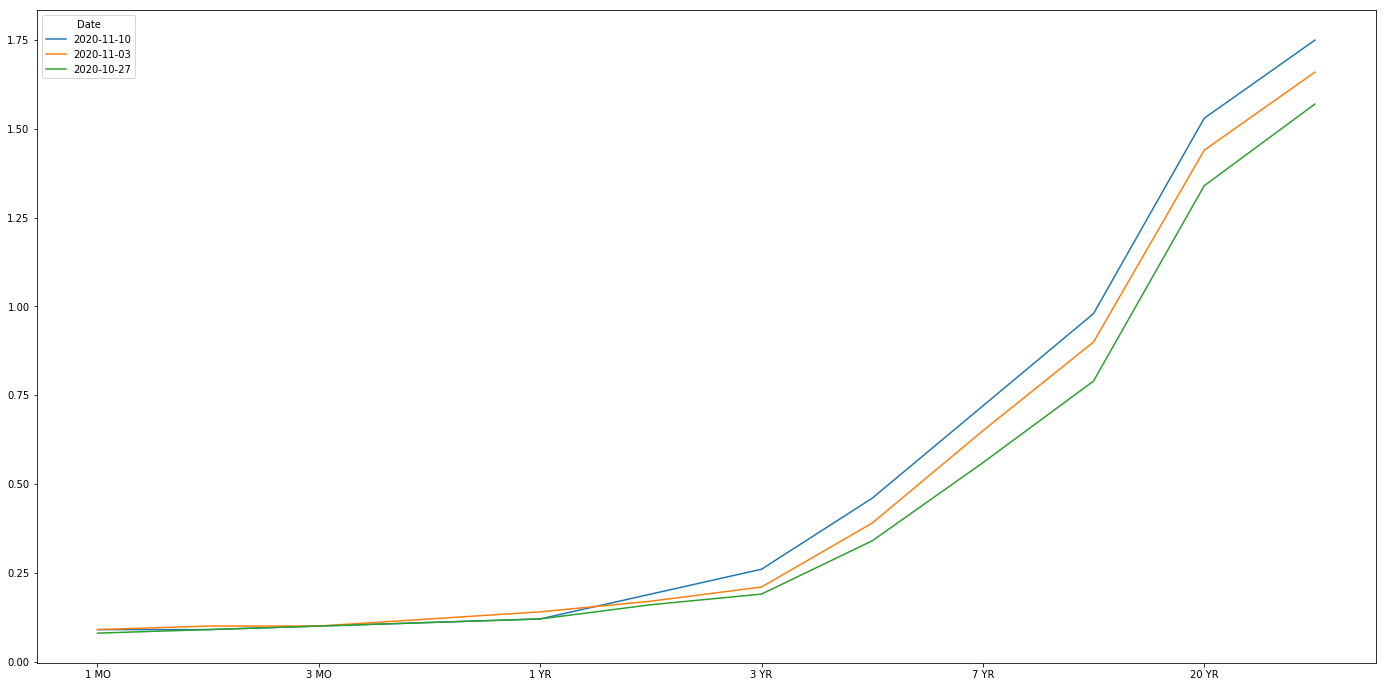

In [187]:
yield_curve.T.plot(figsize=(24, 12))

Largely what I was expecting. The entire yield curve (1 year + maturity) started to shift upwards towards the election (green to orange), and after the election it continued the same move upwards. I am not one for predictions, but I think this says the potential for the Fed to raise rates could start to happen a year or so out, instead of zero for the next few years. 